In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

%matplotlib inline

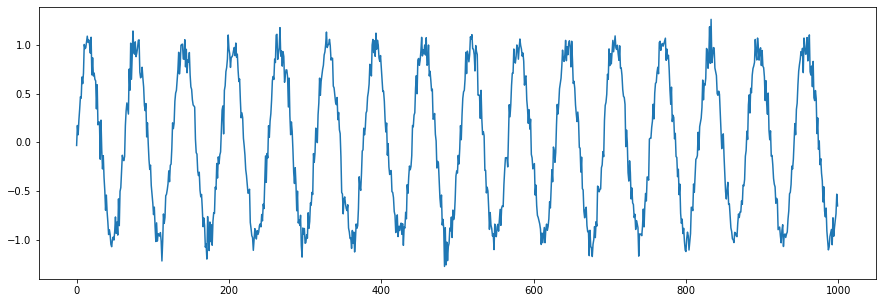

In [2]:
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

plt.figure(figsize=(15, 5))
plt.plot(series)
plt.show()

In [3]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    
    y = series[t + T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"X.shape = {X.shape}, Y.shape = {Y.shape}")

X.shape = (990, 10, 1), Y.shape = (990, 1)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.RNN(
            input_size=self.D, 
            hidden_size=self.M, 
            num_layers=self.L, 
            nonlinearity="relu", 
            batch_first=True
        )
        self.fc = nn.Linear(in_features=self.M, out_features=self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        out, _ = self.rnn(X, h0)
        out = self.fc(out[:, -1, :])    
        
        return out

In [26]:
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

In [28]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [29]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [30]:
def full_gd(model, 
           criterion, 
           optimizer, 
           X_train, 
           y_train, 
           X_test, 
           y_test, 
           epochs=200):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        train_losses[epoch] = loss.item()
        
        loss.backward()
        optimizer.step()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    return train_losses, test_losses

In [31]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/200, Train Loss: 0.1813, Test Loss: 0.1338
Epoch 10/200, Train Loss: 0.1006, Test Loss: 0.1042
Epoch 15/200, Train Loss: 0.0948, Test Loss: 0.0783
Epoch 20/200, Train Loss: 0.0384, Test Loss: 0.0306
Epoch 25/200, Train Loss: 0.0409, Test Loss: 0.0400
Epoch 30/200, Train Loss: 0.0337, Test Loss: 0.0272
Epoch 35/200, Train Loss: 0.0311, Test Loss: 0.0282
Epoch 40/200, Train Loss: 0.0302, Test Loss: 0.0253
Epoch 45/200, Train Loss: 0.0273, Test Loss: 0.0250
Epoch 50/200, Train Loss: 0.0267, Test Loss: 0.0235
Epoch 55/200, Train Loss: 0.0260, Test Loss: 0.0237
Epoch 60/200, Train Loss: 0.0255, Test Loss: 0.0231
Epoch 65/200, Train Loss: 0.0257, Test Loss: 0.0234
Epoch 70/200, Train Loss: 0.0254, Test Loss: 0.0231
Epoch 75/200, Train Loss: 0.0255, Test Loss: 0.0231
Epoch 80/200, Train Loss: 0.0253, Test Loss: 0.0231
Epoch 85/200, Train Loss: 0.0253, Test Loss: 0.0230
Epoch 90/200, Train Loss: 0.0253, Test Loss: 0.0229
Epoch 95/200, Train Loss: 0.0253, Test Loss: 0.0229
Epoch 100/200

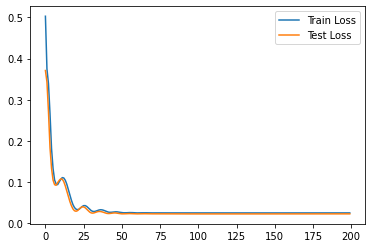

In [32]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

In [39]:
validation_target = Y[-N//2:]
validation_prediction = []

i = 0

while len(validation_prediction) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0, 0].item()
    
    i += 1
    
    validation_prediction.append(p)

In [40]:
model(X_test[0].reshape(1, T, 1))

tensor([[0.1275]], grad_fn=<AddmmBackward>)

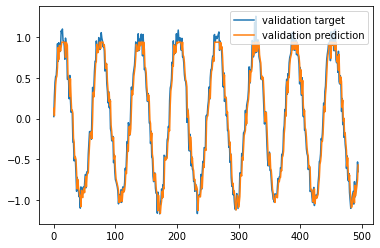

In [41]:
plt.plot(validation_target, label="validation target")
plt.plot(validation_prediction, label="validation prediction")
plt.legend()
plt.show()

In [130]:
validation_target = Y[-N//2:]
validation_prediction = []

last_x = X_test[0].view(T)

while len(validation_prediction) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    validation_prediction.append(p[0, 0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

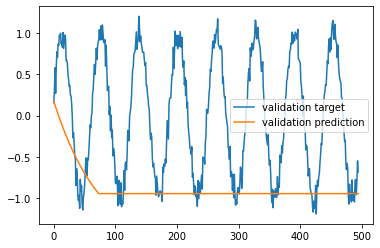

In [131]:
plt.plot(validation_target, label="validation target")
plt.plot(validation_prediction, label="validation prediction")
plt.legend()
plt.show()